In [1]:
using Plots, MFCC, MFCC.Mel, MFCC.Filterbanks

┌ Info: Recompiling stale cache file /home/gabriel/.julia/compiled/v1.0/MFCC/iYOP7.ji for MFCC [0c47adbc-1119-11e9-0b1e-13610b3c3619]
└ @ Base loading.jl:1190



# MFCC

The Mel Frequency Cepstral Coefficients are largely used in the speech recognition field and its application in the field of musical modeling is constantly increasing. The computation process of the MFCC consists in:

1. Computation of the $STFT$
2. Evaluation of the periodogram
3. Creation of the mel scale filterbank
4. Application of the $DCT$

The result is a representation that, although compact, contains a lot of information about the way that the audio signal is perceived. Each one of the steps for its extraction is described next:

## Computation of the $STFT$

First of all, the signal in the time domain must be transformed to the frequency domain. There is no restriction preventing the computation of the cepstral coefficients in the spectrum of the full signal. However, in practical applications it is common to be interesting to know the evolution of the coefficients over the time, which is why the $STFT$ is used to perform the change of domain:

$$X_i[k]=\sum_{n=1}^N{x_i[n]w[n]e^{-2\pi kn/N}}$$

where $x_i[n]$ is the $i$-th frame of the original signal $x[n]$ containing $N$ samples, obtained from the windowing by a function $w[n]$ and $k$ is the number of the harmonic.


## Evaluation of the periodogram

With the signal already in the frequency domain, its periodogram, representation which informs about the distribution of the energy between the frequencies that make up the signal, must be computed. For a frame $X_i[k]$ the periodogram $P_i[k]$ can be computed as:

$$P_i[k]=|X_i[k]|^2$$

## Creation of the mel scale filterbank

The periodogram describe how the energy of each frequency component evolves over time. This representation, in addition to not being compact, doesn't represent well the way that sound is perceived since it uses a linear scale of frequencies. It would be more suitable to use a scale that takes into account the logarithmic nature of the human audition. For this reason the Mel scale is used:

$$\mathrm{Mel}(f) = 1127 \times \ln(1 + f/700)$$

It follows from this definition that the inverse is given by:

$$\mathrm{Mel}^{-1}(m) = 700\times (e^{m/1127} - 1)$$

The scale has the following form:

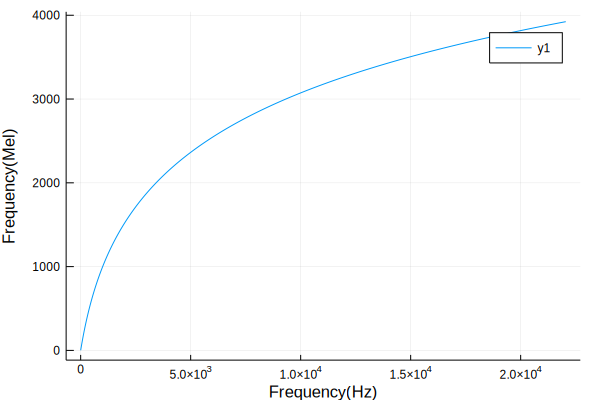

In [2]:
melscale = mel.(range(1, length=22050, 22050))

plot(melscale, xlabel="Frequency(Hz)", ylabel="Frequency(Mel)", fmt = :svg)

The use of the Mel scale solves the issue of auditory non-linearity, but it would also be interesting to take into account the masking phenomenon in the frequency during the design of the filterbank. Since the frequency masking is approximately triangular, the use of windows with this format seems to be very reasonable.

As the hearing ability of distinguishing between close frequencies decreases with increasing frequency it makes sense that the width of the filters is also defined in the Mel scale. In this way, filters at higher frequencies cover a larger bandwidth.

Taking into account a bank with 10 filters for a signal sampled at a frequency of $ 44100Hz and the masking phenomenon and logarithmic distribution, a bank of filters in the Mel scale is designed with the following form:

In [3]:
windows, windowstarts = mffilters(10, 22050, 22050)
filterbank = Filterbank(22050, windows, windowstarts)

plot(melscale, getfilters(filterbank), xlabel="Frequency(Mel)", fmt = :svg)

The triangular windows were normalized to have unitary area. The same filterbank after being brought to the hertz scale would be:

In [4]:
plot(getfilters(filterbank), xlabel="Frequency(Hz)", fmt = :svg)

The design of such a filterbank consists of:
  1. Transform the initial and final frequency to be represented by the coefficients for the Mel scale
  2. Distribute linearly $n + 2$ points where $n$ is the number of coefficients to be obtained between them
  3. Transform the resulting vector back to the hertz scale

The final result of the operation is a vector with $m$ frequencies in hertz spaced in Mel scale:

$$\vec F[m] = \mathrm{Mel}^{-1}( \mathrm{Mel}(F_i) + m \cdot \Delta M)	\qquad \Delta M = \frac{\mathrm{Mel}(F_f) - \mathrm{Mel}(F_i)}{n + 1}, \quad m = 0,1,2...n+1$$

To create the triangular windows of the $n$-th filter, the points of the vector $\vec F$ must be interpolated in the following way:

$$H_n[k] = \begin{cases}
    0   & k \le F[n - 1]\\
    \dfrac{k - F[n - 1]}{F[n] - F[n - 1]} & F[n - 1] < k \le F[n]\\
    \dfrac{F[n + 1] - k}{F[n + 1] - F[n]} & F[n] < k \le F[n + 1]\\
    0   & k > F[n + 1]\\
\end{cases}$$

The coefficients in the Mel scale for each frame are given by the sum of the components of the periodogram after their filtering by the same filter. If the filter bank is placed in the form of an array $H_{n\times N}$

$$H = \begin{bmatrix}
    H_1\\
    H_2\\
    \vdots \\
    H_n
\end{bmatrix}$$

the mel scale coefficients will be the result of the product of $H$ by the periodogram matrix $P_{N\times i}$:

$$MFC = H \times P$$

where $MFC$ is a matrix whose columns are the $n$ coefficients of each frame of the signal.

## Application of the $DCT$

The last step is to take the discrete cosine transform of the coefficients already in mel scale:

$$MFCC = \mathcal{DCT}\{\log(MFC)\}$$

There are multiple definitions of the $\mathcal{DCT}$, but it is common to use the type-3 in the computation of the MFCC. The result obtained is a set of coefficients that contain the cepstral information of each frame of the signal.